## 1. Import Libraries and initialize Hyperparameters

In [44]:
# === IMPORTS === 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils # For plotting grids

import numpy as np
import matplotlib.pyplot as plt
import os

# === VARIABLE INSTANTIATION === 
# model hyperparameters
BATCH_SIZE = 128
IMG_SIZE = 32 # CIFAR-10 is 32x32
CHANNELS = 3
NOISE_DIM = 100 # From assignment baseline
N_CLASSES = 10  # For ACGAN

# set random seed
torch.manual_seed(42)

# create directory to store image results
os.makedirs("images", exist_ok=True)

## 2. Load and Preprocess CIFAR-10 Dataset

In [45]:
# setup GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

# define transforms
transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] range
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Scales to [-1, 1]
])

# load dataset
dataset = datasets.CIFAR10(root=".", train=True, download=True, transform=transform)

# create dataloader
dataloader = data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Using Tesla V100-SXM3-32GB


## 3. Helper Functions

In [46]:
# weight initialization lifted from: https://docs.pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# helper for plotting images: grid of images, 8 images wide 
def plot_generated_images(images, epoch, model_name):
    grid = vutils.make_grid(images, padding=2, normalize=True)
    
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(f"{model_name} - Epoch {epoch}")
    plt.imshow(np.transpose(grid.cpu(), (1, 2, 0)))
    
    # Save the figure
    plt.savefig(f"images/{model_name.lower()}_epoch_{epoch}.png")
    plt.close()

# helper for plotting generator and discriminator loss
def plot_loss(g_loss, d_loss, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(g_loss, label='Generator Loss')
    plt.plot(d_loss, label='Discriminator Loss')
    plt.title(f'{model_name} Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"images/{model_name.lower()}_loss.png")
    plt.close()

## 4. Model 1: DCGAN(Baseline)
DCGAN is a GAN that uses Conv2d and ConvTranspose2d layers(the "DC" in DCGAN) to learn. 

The Generator(G) tries to make images, and the Discriminator(D) tries to geuss if they are "real"(1) or "fake"(0). 

Ideally, the pursuit of G wanting to fool D, and D wanting to get better at catching fakes, produces a model that can recreate images from noisy inputs. 

In [47]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator, self).__init__()
        self.main = nn.Sequential(
            # input: Z (noise) -> (100, 1, 1)
            # project and reshape: (100, 1, 1) -> (512, 4, 4)
            nn.ConvTranspose2d(NOISE_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # block 1: 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # block 2: 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # block 3: 16x16 -> 32x32
            nn.ConvTranspose2d(128, CHANNELS, 4, 2, 1, bias=False),
            
            # output: (3, 32, 32)
            nn.Tanh()
        )

    def forward(self, input):
        # input shape: (batch_size, 100) -> we need (batch_size, 100, 1, 1)
        return self.main(input.view(-1, NOISE_DIM, 1, 1))

# create model, send to device, and init weights
dcgan_generator = DCGAN_Generator().to(device)
dcgan_generator.apply(weights_init)
print("DCGAN(G) Structure: ") 
print(dcgan_generator)

DCGAN(G) Structure: 
DCGAN_Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [48]:
class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input: (3, 32, 32)
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # block 1: (64, 16, 16) -> (128, 8, 8)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # block 2: (128, 8, 8) -> (256, 4, 4)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # block 3: (256, 4, 4) -> (1, 1, 1)
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            
            # squeeze to a single value
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1) # Flatten to (batch_size, 1)

# create model, send to device, and init weights
dcgan_discriminator = DCGAN_Discriminator().to(device)
dcgan_discriminator.apply(weights_init)
print("DCGAN(D) Structure: ") 
print(dcgan_discriminator)

DCGAN(D) Structure: 
DCGAN_Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [49]:
# === OPTIMIZERS AND LOSS === 
# used the Adam config from the slides
g_lr = 0.0002
d_lr = 0.0001
beta1 = 0.5
g_optimizer_dcgan = optim.Adam(dcgan_generator.parameters(), lr=g_lr, betas=(beta1, 0.999))
d_optimizer_dcgan = optim.Adam(dcgan_discriminator.parameters(), lr=d_lr, betas=(beta1, 0.999))

# standard binary cross entropy loss
criterion = nn.BCELoss()

# fixed noise for plotting
fixed_noise = torch.randn(64, NOISE_DIM, device=device)

# create real/fake labels
real_label = 1.0
fake_label = 0.0

# === TRAINING FUNCTION ===
def train_dcgan(epochs):
    print("Starting DCGAN Training...")
    g_loss_history = []
    d_loss_history = []

    for epoch in range(epochs):
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        for i, (real_images, _) in enumerate(dataloader):
            # --- 1. train discriminator(D) ---
            # maximize log(D(x)) + log(1 - D(G(z)))
            # reset gradients
            d_optimizer_dcgan.zero_grad()
            
            # batch of real images and get output
            real_images = real_images.to(device)
            current_batch_size = real_images.size(0)
            labels = torch.full((current_batch_size, 1), real_label, device=device)

            output_real = dcgan_discriminator(real_images)
            errD_real = criterion(output_real, labels)
            errD_real.backward()

            # batch of fake images and get output
            noise = torch.randn(current_batch_size, NOISE_DIM, device=device)
            fake_images = dcgan_generator(noise)
            labels.fill_(fake_label) 

            output_fake = dcgan_discriminator(fake_images.detach()) # Detach from G
            errD_fake = criterion(output_fake, labels)
            errD_fake.backward()
            
            # total D loss
            errD = errD_real + errD_fake
            d_optimizer_dcgan.step() # Update D

            # --- 2. train generator(G) ---
            # maximize log(D(G(z)))
            # reset gradients
            g_optimizer_dcgan.zero_grad()
            
            # G's goal is to make D think the fake images are real
            labels.fill_(real_label) # Use real labels (1s)
            
            # get D's output on the *new* fake images
            output = dcgan_discriminator(fake_images)
            errG = criterion(output, labels)
            errG.backward()
            
            g_optimizer_dcgan.step() # Update G
            
            # log losses
            epoch_g_loss += errG.item()
            epoch_d_loss += errD.item()

        # log and plot
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_d_loss = epoch_d_loss / len(dataloader)
        g_loss_history.append(avg_g_loss)
        d_loss_history.append(avg_d_loss)

        # print progress every 10 epochs and on first epoch
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"DCGAN Epoch {epoch+1}/{epochs} - G_Loss: {avg_g_loss:.4f}, D_Loss: {avg_d_loss:.4f}")
            with torch.no_grad():
                fake_plot_imgs = dcgan_generator(fixed_noise).detach().cpu()
                plot_generated_images(fake_plot_imgs, epoch + 1, "DCGAN")

    print("DCGAN Training Finished.")
    plot_loss(g_loss_history, d_loss_history, "DCGAN")
    return g_loss_history, d_loss_history

# === RUN DCGAN TRAINING === 
EPOCHS_DCGAN = 100
dcgan_g_loss, dcgan_d_loss = train_dcgan(EPOCHS_DCGAN)

Starting DCGAN Training...
DCGAN Epoch 1/100 - G_Loss: 1.7692, D_Loss: 1.4491
DCGAN Epoch 10/100 - G_Loss: 1.1951, D_Loss: 1.2055
DCGAN Epoch 20/100 - G_Loss: 1.2530, D_Loss: 1.1205
DCGAN Epoch 30/100 - G_Loss: 1.2093, D_Loss: 1.1021
DCGAN Epoch 40/100 - G_Loss: 1.3265, D_Loss: 1.0571
DCGAN Epoch 50/100 - G_Loss: 1.4372, D_Loss: 0.9659
DCGAN Epoch 60/100 - G_Loss: 1.5665, D_Loss: 0.9284
DCGAN Epoch 70/100 - G_Loss: 1.7187, D_Loss: 0.8611
DCGAN Epoch 80/100 - G_Loss: 1.8766, D_Loss: 0.7569
DCGAN Epoch 90/100 - G_Loss: 2.0286, D_Loss: 0.6846
DCGAN Epoch 100/100 - G_Loss: 2.1950, D_Loss: 0.6449
DCGAN Training Finished.


## 5. Model 2: WGAN
WGANs or Wasserstein GAN is a model that is designed as a fix for the inherent instability of DCGANs. 

Instead of 0/1 "fake" guesses, the introduction of "Critic" in place of the regular Discriminator(D) gives a score. 

Think of the Critic like a teacher. DCGAN just returns "F" or 0, WGAN says "you got a 30/100"(an actual score), which provides far more helpful feedback for the Generator(G) to learn from. 

In [50]:
# === BUILD WGAN CRITIC, WHICH IS REQUIRED IN PLACE OF THE DISCRIMINATOR === 
class WGAN_Critic(nn.Module):
    def __init__(self):
        super(WGAN_Critic, self).__init__()
        self.main = nn.Sequential(
            # input: (3, 32, 32)
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # block 1: (64, 16, 16)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # block 2: (128, 8, 8)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # block 3: (256, 4, 4)
            nn.Conv2d(256, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1) # Flatten to (batch_size, 1)

# can use the same Generator class as DCGAN
print("WGAN(D/C) Structure: ") 
wgan_generator = DCGAN_Generator().to(device)
wgan_critic = WGAN_Critic().to(device)
wgan_generator.apply(weights_init)
wgan_critic.apply(weights_init)

WGAN(D/C) Structure: 


WGAN_Critic(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [51]:
# === WGAN TRAINING LOOP === 
# optimizers
g_lr_wgan = 0.00005
d_lr_wgan = 0.00004
g_optimizer_wgan = optim.RMSprop(wgan_generator.parameters(), lr=g_lr_wgan)
d_optimizer_wgan = optim.RMSprop(wgan_critic.parameters(), lr=d_lr_wgan)

# hyperparameters
clip_value = 0.01
N_CRITIC = 5

# training 
def train_wgan(epochs):
    print("Starting WGAN Training...")
    g_loss_history = []
    d_loss_history = []

    for epoch in range(epochs):
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0
        
        for i, (real_images, _) in enumerate(dataloader):
            # --- 1. train Critic(D), as it replaces Discriminator ---
            # train N_CRITIC times
            for _ in range(N_CRITIC):
                d_optimizer_wgan.zero_grad()
                
                # real images
                real_images = real_images.to(device)
                current_batch_size = real_images.size(0)
                output_real = wgan_critic(real_images)
                
                # fake images
                noise = torch.randn(current_batch_size, NOISE_DIM, device=device)
                fake_images = wgan_generator(noise)
                output_fake = wgan_critic(fake_images.detach())
                
                # WGAN loss: E[D(G(z))] - E[D(x)]
                errD = torch.mean(output_fake) - torch.mean(output_real)
                errD.backward()
                d_optimizer_wgan.step()

                # clip critic weights
                for p in wgan_critic.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            # --- 2. train Generator(G) ---
            # done once per batch, after critic is completed
            g_optimizer_wgan.zero_grad()
            
            # create new fake images
            noise = torch.randn(current_batch_size, NOISE_DIM, device=device)
            fake_images = wgan_generator(noise)
            output = wgan_critic(fake_images)
            
            # G Loss: -E[D(G(z))]
            errG = -torch.mean(output)
            errG.backward()
            g_optimizer_wgan.step()

            # log losses
            epoch_g_loss += errG.item()
            epoch_d_loss += errD.item()
        
        # log and plot
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_d_loss = epoch_d_loss / len(dataloader)
        g_loss_history.append(avg_g_loss)
        d_loss_history.append(avg_d_loss)

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"WGAN Epoch {epoch+1}/{epochs} - G_Loss: {avg_g_loss:.4f}, D_Loss: {avg_d_loss:.4f}")
            with torch.no_grad():
                fake_plot_imgs = wgan_generator(fixed_noise).detach().cpu()
                plot_generated_images(fake_plot_imgs, epoch + 1, "WGAN")

    print("WGAN Training Finished.")
    plot_loss(g_loss_history, d_loss_history, "WGAN")
    return g_loss_history, d_loss_history

# === RUN WGAN TRAINING === 
EPOCHS_WGAN = 100
wgan_g_loss, wgan_d_loss = train_wgan(EPOCHS_WGAN)

Starting WGAN Training...
WGAN Epoch 1/100 - G_Loss: 0.1420, D_Loss: -0.2679
WGAN Epoch 10/100 - G_Loss: 0.1073, D_Loss: -0.2154
WGAN Epoch 20/100 - G_Loss: 0.0732, D_Loss: -0.1585
WGAN Epoch 30/100 - G_Loss: 0.0580, D_Loss: -0.1305
WGAN Epoch 40/100 - G_Loss: 0.0491, D_Loss: -0.1121
WGAN Epoch 50/100 - G_Loss: 0.0398, D_Loss: -0.1012
WGAN Epoch 60/100 - G_Loss: 0.0382, D_Loss: -0.0914
WGAN Epoch 70/100 - G_Loss: 0.0345, D_Loss: -0.0839
WGAN Epoch 80/100 - G_Loss: 0.0293, D_Loss: -0.0774
WGAN Epoch 90/100 - G_Loss: 0.0267, D_Loss: -0.0725
WGAN Epoch 100/100 - G_Loss: 0.0240, D_Loss: -0.0645
WGAN Training Finished.


## 6. Generate Final Images for Report

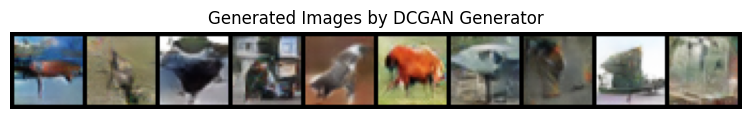

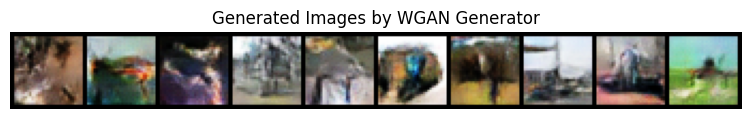

In [52]:
# generates and saves a batch of images from the trained models 
def save_final_images(generator, n_images, model_name):
    output_dir = f"{model_name}_final_images"
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Saving {n_images} images to '{output_dir}/'...")
    
    noise = torch.randn(n_images, NOISE_DIM, device=device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()

    for i in range(n_images):
        vutils.save_image(generated_images[i], os.path.join(output_dir, f"{model_name}_{i+1:03d}.png"), normalize=True)
    print("...Done.")

# select 10 images and plot in a grid fashion
def show_final_grid(generator, n_images, title):
    noise = torch.randn(n_images, NOISE_DIM, device=device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    
    grid = vutils.make_grid(generated_images, nrow=n_images, padding=2, normalize=True)
    
    plt.figure(figsize=(10, 1)) # 10 images, 1-inch wide each
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()

# produce output for DCGAN and WGAN
show_final_grid(dcgan_generator, 10, "Generated Images by DCGAN Generator")
show_final_grid(wgan_generator, 10, "Generated Images by WGAN Generator")